In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation

2024-01-13 00:28:31.912031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 00:28:31.912088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-13 00:28:31.912832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 00:28:31.919092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 00:28:32.918333: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:15]}

In [11]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      with_labels=True,
                                      train_val_split=0.8, input_stride=4, padding='none',
                                      input_history_steps=60, input_future_steps=60, seed=69)

=========================Creating Generator=======================
Seed: 69
nTrain: 200 nVal: 50 (0.80)
Padding: none
Scaling: True 
Horizons: 60-60 @ stride 4
Sin-Transformed features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)']
=========================Finished Generator=======================


In [12]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=512, label_features=['EW_Type', 'NS_Type'], with_identifier=False, shuffle=True, stride=2)
# train_combined = train_combined.filter(lambda x,y:y['EW_Node_Location']==1)
# val_combined = val_combined.filter(lambda x,y:y['EW_Node_Location']==1)
# train_combined = train_combined.map(lambda x,y:(x,{'EW':y['EW']}))
# val_combined = val_combined.map(lambda x,y:(x,{'EW':y['EW']}))
# train_combined = train_combined.batch(32)
# val_combined = val_combined.batch(32)
print(train_combined.element_spec)

(TensorSpec(shape=(None, 30, 9), dtype=tf.float64, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 30, 9)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 270)                  0         ['Input[0][0]']               
                                                                                                  
 dense (Dense)               (None, 256)                  69376     ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                              

2024-01-13 00:39:27.473687: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3ddc018180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-13 00:39:27.473741: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-01-13 00:39:27.481652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-13 00:39:28.042818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1705102768.138152   93030 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


403/403 [==============================] - 9s 13ms/step - loss: 2.0269 - EW_Type_loss: 1.0702 - NS_Type_loss: 0.9567 - EW_Type_accuracy: 0.7510 - NS_Type_accuracy: 0.6515 - val_loss: 6.1568 - val_EW_Type_loss: 3.7739 - val_NS_Type_loss: 2.3829 - val_EW_Type_accuracy: 0.5767 - val_NS_Type_accuracy: 0.4666
Epoch 2/2
403/403 [==============================] - 5s 13ms/step - loss: 1.6699 - EW_Type_loss: 0.7071 - NS_Type_loss: 0.9628 - EW_Type_accuracy: 0.7535 - NS_Type_accuracy: 0.6424 - val_loss: 6.4992 - val_EW_Type_loss: 3.4340 - val_NS_Type_loss: 3.0652 - val_EW_Type_accuracy: 0.6170 - val_NS_Type_accuracy: 0.4657
Finished training after 2 epochs.
Evaluating model:
101/101 [==============================] - 1s 7ms/step - loss: 6.4992 - EW_Type_loss: 3.4340 - NS_Type_loss: 3.0652 - EW_Type_accuracy: 0.6170 - NS_Type_accuracy: 0.4657


/home/david/Code/splid-challenge/base/prediction_models.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


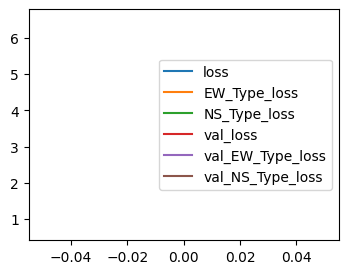

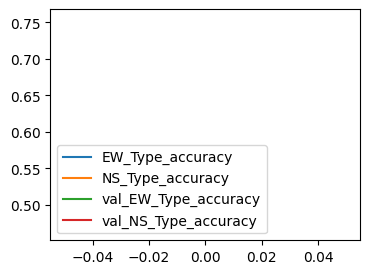

In [15]:
#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.15, lstm_layers=[48,48], dense_layers=[16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)

dense_model.summary()
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=2, verbose=1, plot_hist=False, callbacks=[])
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [8]:
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=20, verbose=1, plot_hist=False, callbacks=[])


Starting training. Optimizing "val_accuracy"
Epoch 1/20
852/852 [==============================] - 22s 26ms/step - loss: 1.5454 - EW_loss: 0.6271 - NS_loss: 0.8707 - EW_accuracy: 0.7765 - NS_accuracy: 0.7154 - val_loss: 2.4265 - val_EW_loss: 1.1024 - val_NS_loss: 1.2770 - val_EW_accuracy: 0.6440 - val_NS_accuracy: 0.6105
Epoch 2/20
852/852 [==============================] - 24s 28ms/step - loss: 1.6361 - EW_loss: 0.6746 - NS_loss: 0.9136 - EW_accuracy: 0.7575 - NS_accuracy: 0.6776 - val_loss: 2.8408 - val_EW_loss: 1.2808 - val_NS_loss: 1.5124 - val_EW_accuracy: 0.6138 - val_NS_accuracy: 0.5791
Epoch 3/20
852/852 [==============================] - 23s 27ms/step - loss: 1.4995 - EW_loss: 0.6038 - NS_loss: 0.8466 - EW_accuracy: 0.7822 - NS_accuracy: 0.7180 - val_loss: 2.5713 - val_EW_loss: 1.1571 - val_NS_loss: 1.3650 - val_EW_accuracy: 0.6440 - val_NS_accuracy: 0.6036
Epoch 4/20
852/852 [==============================] - 22s 26ms/step - loss: 1.6004 - EW_loss: 0.6656 - NS_loss: 0.8848 - 

In [18]:
def evaluate_classifier(ds_gen, gt_path, model, model_outputs=['EW', 'NS'], train=True, with_initial_node=True, return_scores=False, verbose=2):

    t_ds, v_ds = ds_gen.get_datasets(batch_size=None, label_features=model_outputs + ['EW_Node_Location', 'NS_Node_Location'], shuffle=False, with_identifier=True, stride=1)
    ds = t_ds if train else v_ds

    # only predict on the necessary locations to speed things up
    ds = ds.filter(lambda x,y,z:y['EW_Node_Location']==1 or y['NS_Node_Location']==1)
    ds = ds.batch(256)

    ground_truth_df = pd.read_csv(gt_path).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_df = ground_truth_df[ground_truth_df['ObjectID'].isin(map(int, ds_gen.train_keys if train else ds_gen.val_keys))].copy()

    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    #labels = np.concatenate([element['EW_Node_Location'] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])

    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    # get predictions
    preds = model.predict(inputs, verbose=verbose)

    # Ordering of model_outputs MUST MATCH with actual outputs!
    for output_idx, output_name in enumerate(model_outputs):
        preds_argmax = np.argmax(preds[output_idx] if len(model_outputs) > 1 else preds, axis=1)
        df[f'{output_name}_Pred'] = preds_argmax
        if output_name == 'EW_Node' or output_name == 'NS_Node':
            df[f'{output_name}'] = ds_gen.node_label_encoder.inverse_transform(df[f'{output_name}_Pred'])
        if output_name == 'EW_Type' or output_name == 'NS_Type':
            df[f'{output_name}'] = ds_gen.type_label_encoder.inverse_transform(df[f'{output_name}_Pred'])
        if output_name == 'EW' or output_name == 'NS':
            df[f'{output_name}'] = ds_gen.combined_label_encoder.inverse_transform(df[f'{output_name}_Pred'])
            df[[f'{output_name}_Node', f'{output_name}_Type']] = df[f'{output_name}'].str.split('-', expand=True)
    
    # now, assign the real label to the locations
    if not ('EW_Node' in model_outputs or 'EW_Type' in model_outputs or 'EW_Node' in model_outputs):
        if verbose > 0: print("Considering only NS direction")
        ground_truth_df = ground_truth_df[(ground_truth_df['Direction'] == 'NS')]
    if not ('NS_Node' in model_outputs or 'NS_Type' in model_outputs or 'NS_Node' in model_outputs):
        if verbose > 0: print("Considering only EW direction")
        ground_truth_df = ground_truth_df[(ground_truth_df['Direction'] == 'EW')]
    gt_columns_to_keep = ['ObjectID', 'TimeIndex', 'Direction'] # available: direction, node, type
    if not ('NS_Node' in model_outputs or 'EW_Node' in model_outputs or 'EW' in model_outputs or 'NS' in model_outputs):
        if verbose > 0: print("Assuming perfect nodes")
        gt_columns_to_keep += ['Node']
    if not ('NS_Type' in model_outputs or 'EW_Type' in model_outputs or 'EW' in model_outputs or 'NS' in model_outputs):
        gt_columns_to_keep += ['Type']
        if verbose > 0: print("Assuming perfect types")
    df = df.merge(ground_truth_df[gt_columns_to_keep], how='right', on = ['ObjectID', 'TimeIndex'])

    if not 'Type' in df.columns.values.tolist():
        df['Type'] = pd.NA
    if not 'Node' in df.columns.values.tolist():
        df['Node'] = pd.NA
    if 'EW_Node' in df.columns.values.tolist():
        df.loc[df['Direction'] == 'EW', 'Node'] = df.loc[df['Direction'] == 'EW', 'EW_Node']
    if 'EW_Type' in df.columns.values.tolist():
        df.loc[df['Direction'] == 'EW', 'Type'] = df.loc[df['Direction'] == 'EW', 'EW_Type']
    if 'NS_Node' in df.columns.values.tolist():
        df.loc[df['Direction'] == 'NS', 'Node'] = df.loc[df['Direction'] == 'NS', 'NS_Node']
    if 'NS_Type' in df.columns.values.tolist():
        df.loc[df['Direction'] == 'NS', 'Type'] = df.loc[df['Direction'] == 'NS', 'NS_Type']

    # Lets add our background knowledge:
    # 1) For timeindex 0, the node is always SS
    df.loc[df['TimeIndex'] == 0, 'Node'] = 'SS'
    # 2) AD, ID is always combined with NK
    df.loc[(df['Node'] == 'AD') | (df['Node'] == 'ID'), 'Type'] = 'NK'
    # 3) IK is always combined with HK/CK/EK
    df.loc[(df['Node'] == 'IK') & (df['Type'] == 'NK'), 'Type'] = 'CK' # CK is most common

    # remove ES rows
    df = df.replace('na', pd.NA)
    df.dropna(inplace=True)

    # remove initial nodes
    if not with_initial_node:
        df = df.loc[df['TimeIndex'] != 0]

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=df)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    if verbose > 0:
        print(f'Precision: {precision:.2f}')
        print(f'TP: {total_tp} FP: {total_fp}')

    if return_scores:
        return {'Precision':precision, 'TP':total_tp, 'FP':total_fp}
    else:
        return df, ground_truth_df

In [19]:
eval_df, gt_df = evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, model_outputs=['EW_Type', 'NS_Type'], train=False)
print(eval_df.head(20))
# Dense: worse
# LSTM 40-40@2 same-padding: 0.51
# LSTM 40-40@2 zero-padding: 0.49
# LSTM 80-80@5: 0.49

2/2 - 0s - 93ms/epoch - 47ms/step
Assuming perfect nodes
Precision: 0.73
TP: 51 FP: 19
    ObjectID  TimeIndex  EW_Type_Pred EW_Type  NS_Type_Pred NS_Type Direction  \
2         10        216           0.0      CK           3.0      NK        NS   
60       104         99           0.0      CK           3.0      NK        EW   
61       104        126           0.0      CK           3.0      NK        EW   
62       104        239           0.0      CK           3.0      NK        NS   
66       114        200           0.0      CK           3.0      NK        EW   
67       114        206           0.0      CK           3.0      NK        EW   
68       114        239           0.0      CK           0.0      CK        NS   
72       115        200           0.0      CK           3.0      NK        EW   
73       115        206           0.0      CK           3.0      NK        EW   
74       115        239           0.0      CK           0.0      CK        NS   
78       116        20

In [18]:
print(gt_df.head(30))

     ObjectID  TimeIndex Direction Node Type
28         10          0        EW   SS   CK
29         10          0        NS   SS   NK
30         10        216        NS   IK   CK
31         10       2171        ES   ES   ES
45         15          0        EW   SS   EK
46         15          0        NS   SS   CK
47         15       2171        ES   ES   ES
64         21          0        EW   SS   HK
65         21          0        NS   SS   HK
66         21       2171        ES   ES   ES
79         26          0        EW   SS   CK
80         26          0        NS   SS   CK
81         26       2207        ES   ES   ES
91         30          0        EW   SS   CK
92         30          0        NS   SS   NK
93         30       2207        ES   ES   ES
109        36          0        EW   SS   CK
110        36          0        NS   SS   NK
111        36       2171        ES   ES   ES
136        45          0        EW   SS   CK
137        45          0        NS   SS   CK
138       

In [10]:
print(ds_gen.val_keys)

['10', '104', '114', '115', '116', '119', '121', '123', '137', '139', '148', '15', '160', '161', '167', '171', '176', '184', '185', '193', '198', '199', '21', '211', '212', '221', '222', '227', '230', '233', '235', '238', '241', '245', '26', '30', '36', '45', '47', '50', '52', '60', '61', '66', '67', '73', '84', '87', '88', '91']


In [10]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True)
# LSTM 40-40@2: 0.49
# LSTM 40-40@2 zero-padding: 0.52
# LSTM 80-80@5: 0.51

14/14 [==============================] - 0s 11ms/step
Precision: 0.52
TP: 367 FP: 336


In [10]:
print(eval_df['Type'].unique())

['CK' 'NK']


In [23]:

labels=pd.read_csv(labels_dir)
labels = labels.loc[(labels['ObjectID'].isin(map(int, ds_gen.val_keys)))]
labels = labels.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(len(labels) - (len(ds_gen.val_keys)*3))
print(labels.head(5))

70
   ObjectID  TimeIndex Direction Node Type
0        10          0        EW   SS   CK
1        10          0        NS   SS   NK
2        10        216        NS   IK   CK
3        10       2171        ES   ES   ES
4        15          0        EW   SS   EK
